## Dataset Installation

In [1]:
!pip install -qq medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Imports

In [2]:
import os
import io
import imageio
import medmnist
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Establishing a consistent environment for model training
RANDOM_SEED = 42  # Seed value for reproducibility
os.environ["TF_DETERMINISM_CONTROL"] = "1"  # Enforcing deterministic behavior in TensorFlow
# Setting the seed for Keras
keras.utils.set_random_seed(RANDOM_SEED)

## Hyperparameters

The hyperparameters are chosen via hyperparameter
search.

In [3]:
# Configuration for Dataset
DATA_SOURCE = "organmnist3d"  # Dataset identifier
BATCH_SIZE = 32  # Size of each batch for training
DATA_TUNING = tf.data.AUTOTUNE  # Auto-tuning setting for data loading
VOLUME_SHAPE = (28, 28, 28, 1)  # Shape of the input data (3D volumes)
TOTAL_CLASSES = 11  # Total number of classes in the dataset

# Hyperparameters for Optimizer
LEARNING_RATE = 1e-4  # Initial learning rate for optimization
DECAY_RATE = 1e-5  # Decay rate for weights in the optimizer

# Parameters for Training Process
TRAINING_EPOCHS = 60  # Total number of training epochs

# Configuration for Tubelet Embeddings
PATCH_DIMENSIONS = (8, 8, 8)  # Size of each patch in the tubelet
PATCH_COUNT = (VOLUME_SHAPE[0] // PATCH_DIMENSIONS[0]) ** 2  # Total number of patches

# Settings for ViViT Architecture
NORM_EPSILON = 1e-6  # Epsilon value for layer normalization
EMBEDDING_DIM = 128  # Dimensionality of the projection/embedding
ATTENTION_HEADS = 8  # Number of attention heads in transformer layers
TRANSFORMER_LAYERS = 8  # Number of transformer layers in the architecture


## Data Preparation and Loading

To ensure the model has the necessary data for training and evaluation, the `fetch_and_setup_data` function is utilized for downloading and setting up the dataset. This function performs the following operations:

- **Downloading Dataset:** Retrieves the dataset from the specified URL and verifies integrity using MD5 hash.
- **Data Extraction:** Extracts the video data and corresponding labels from the dataset files.
- **Data Separation:** Splits the dataset into three distinct sets: training, validation, and testing. This separation is crucial for training the model and evaluating its performance effectively.

The dataset metadata is retrieved from MedMNIST, and the `fetch_and_setup_data` function is called with this metadata to acquire the necessary data.

### Dataset Split
- **Training Set:** Used to train the model.
- **Validation Set:** Used to tune the hyperparameters and evaluate the model during training.
- **Testing Set:** Used to assess the model's performance after training.

This setup ensures a comprehensive approach to model training and evaluation, providing a robust framework for accurate performance assessment.


In [4]:
def fetch_and_setup_data(data_details: dict):
    """Download and arrange the dataset.

    Parameters:
        data_details (dict): Information about the dataset.
    """
    dataset_url = data_details["url"]
    dataset_md5 = data_details["MD5"]
    dataset_path = keras.utils.get_file(origin=dataset_url, md5_hash=dataset_md5)

    with np.load(dataset_path) as dataset_files:
        # Extracting video data
        training_videos = dataset_files["train_images"]
        validation_videos = dataset_files["val_images"]
        testing_videos = dataset_files["test_images"]

        # Extracting corresponding labels
        training_labels = dataset_files["train_labels"].flatten()
        validation_labels = dataset_files["val_labels"].flatten()
        testing_labels = dataset_files["test_labels"].flatten()

    return (
        (training_videos, training_labels),
        (validation_videos, validation_labels),
        (testing_videos, testing_labels),
    )

# Retrieving dataset metadata
dataset_info = medmnist.INFO[DATA_SOURCE]

# Acquiring the dataset
assembled_data = fetch_and_setup_data(dataset_info)
(training_videos, training_labels) = assembled_data[0]
(validation_videos, validation_labels) = assembled_data[1]
(testing_videos, testing_labels) = assembled_data[2]


32657407/32657407 [==============================] - 5s 0us/step


## Data Processing and Loader Setup

### Data Transformation
The `transform_data` function is decorated with `@tf.function` for efficient execution as a TensorFlow graph. This function serves two primary purposes:

- **Video Data Transformation:** Converts the video data tensors into a format compatible with the model. This includes changing the data type to `tf.float32` and adding a new axis to accommodate 3D convolution requirements.
- **Category Label Processing:** Converts the category labels into a `tf.float32` format, ensuring they are suitable for model training and evaluation.

### Batch Loader Creation
The `setup_batch_loader` function creates TensorFlow data loaders, which are essential for efficiently feeding data to the model during training and evaluation. Key functionalities include:

- **Dataset Slicing:** Creates TensorFlow datasets from video data and corresponding labels.
- **Shuffling:** Applies only to the training dataset to ensure the model does not learn any inherent order in the data, thus improving generalization.
- **Batching and Prefetching:** Organizes data into batches for more efficient training and employs prefetching to improve data loading speed.

Separate loaders are created for each dataset split (training, validation, and testing), ensuring that the model has the right data during each phase of training and evaluation.

### Loaders
- **Training Loader:** Used for model training.
- **Validation Loader:** Used for model validation during training.
- **Testing Loader:** Used for final evaluation of the model's performance.

These loaders streamline the process of data handling, significantly impacting the model's training efficiency and performance.

In [5]:
@tf.function
def transform_data(video_data: tf.Tensor, category: tf.Tensor):
    """Transform video data tensors and process the category labels."""
    # Transform video frames for model compatibility
    video_data = tf.image.convert_image_dtype(
        video_data[..., tf.newaxis],  # Adding a new axis for 3D convolution compatibility
        tf.float32,
    )
    # Process category label into a float32 format
    category = tf.cast(category, tf.float32)
    return video_data, category


def setup_batch_loader(
    video_array: np.ndarray,
    category_labels: np.ndarray,
    loader_kind: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Create a data loader for batching and preprocessing."""
    data_set = tf.data.Dataset.from_tensor_slices((video_array, category_labels))

    if loader_kind == "train":
        data_set = data_set.shuffle(BATCH_SIZE * 2)

    batch_loader = (
        data_set.map(transform_data, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return batch_loader


training_loader = setup_batch_loader(training_videos, training_labels, "train")
validation_loader = setup_batch_loader(validation_videos, validation_labels, "valid")
testing_loader = setup_batch_loader(testing_videos, testing_labels, "test")


## Tubelet Embedding


In [6]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, dimensionality, size_of_patch, **kwargs):
        super().__init__(**kwargs)
        self.patch_projection = layers.Conv3D(
            filters=dimensionality,
            kernel_size=size_of_patch,
            strides=size_of_patch,
            padding="VALID",
        )
        self.patch_flattening = layers.Reshape(target_shape=(-1, dimensionality))

    def call(self, video_samples):
        projected_video_patches = self.patch_projection(video_samples)
        flattened_video_patches = self.patch_flattening(projected_video_patches)
        return flattened_video_patches


## Positional Embedding

This layer adds positional information to the encoded video tokens.

In [7]:
class PositionalEncoder(layers.Layer):
    def __init__(self, dimensionality, **kwargs):
        super().__init__(**kwargs)
        self.dimensionality = dimensionality

    def build(self, shape_of_input):
        _, count_tokens, _ = shape_of_input
        self.token_position_embedding = layers.Embedding(
            input_dim=count_tokens, output_dim=self.dimensionality
        )
        self.token_positions = tf.range(start=0, limit=count_tokens, delta=1)

    def call(self, token_sequences):
        # Adding position information to the token sequences
        positionally_encoded_tokens = self.token_position_embedding(self.token_positions)
        token_sequences += positionally_encoded_tokens
        return token_sequences


## Video Vision Transformer


In [8]:
def build_vivit_model(
    patch_embedder,
    token_position_encoder,
    volume_shape=VOLUME_SHAPE,
    transformer_layer_count=TRANSFORMER_LAYERS,
    attention_head_count=ATTENTION_HEADS,
    embedding_dimension=EMBEDDING_DIM,
    normalization_epsilon=NORM_EPSILON,
    class_count=TOTAL_CLASSES,
):
    # Initializing the input tensor
    input_tensor = layers.Input(shape=volume_shape)
    # Generating patches from input
    patch_outputs = patch_embedder(input_tensor)
    # Adding positional encoding to patches
    position_encoded_patches = token_position_encoder(patch_outputs)

    # Constructing Transformer layers
    for _ in range(transformer_layer_count):
        # Applying layer normalization and multi-head self-attention
        layer_normed = layers.LayerNormalization(epsilon=1e-6)(position_encoded_patches)
        self_attention_output = layers.MultiHeadAttention(
            num_heads=attention_head_count, key_dim=embedding_dimension // attention_head_count, dropout=0.1
        )(layer_normed, layer_normed)

        # Residual connection
        residual_connection_1 = layers.Add()([self_attention_output, position_encoded_patches])

        # Further normalization and dense layers
        normalized_dense_output = layers.LayerNormalization(epsilon=1e-6)(residual_connection_1)
        normalized_dense_output = keras.Sequential(
            [
                layers.Dense(units=embedding_dimension * 4, activation=tf.nn.gelu),
                layers.Dense(units=embedding_dimension, activation=tf.nn.gelu),
            ]
        )(normalized_dense_output)

        # Second residual connection
        position_encoded_patches = layers.Add()([normalized_dense_output, residual_connection_1])

    # Final layer normalization and pooling
    final_representation = layers.LayerNormalization(epsilon=normalization_epsilon)(position_encoded_patches)
    final_representation = layers.GlobalAvgPool1D()(final_representation)

    # Output classification layer
    classification_output = layers.Dense(units=class_count, activation="softmax")(final_representation)

    # Constructing the Keras model
    model = keras.Model(inputs=input_tensor, outputs=classification_output)
    return model


## Train

In [9]:
from keras.callbacks import EarlyStopping

def launch_model_training():
    # Constructing the ViViT model
    vivit_model = build_vivit_model(
        patch_embedder=TubeletEmbedding(
            dimensionality=EMBEDDING_DIM, size_of_patch=PATCH_DIMENSIONS
        ),
        token_position_encoder=PositionalEncoder(dimensionality=EMBEDDING_DIM),
    )

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    # Setting up the model with optimizer and evaluation metrics
    optimization_algorithm = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    vivit_model.compile(
        optimizer=optimization_algorithm,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="model_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_model_accuracy"),
        ],
    )

    # Commencing the training process
    history = vivit_model.fit(
        training_loader,
        epochs=TRAINING_EPOCHS,
        validation_data=validation_loader,
        callbacks=[early_stopping]
    )

    # Evaluating the model performance on the test dataset
    _, final_accuracy, final_top_5_accuracy = vivit_model.evaluate(testing_loader)
    print(f"Test accuracy: {round(final_accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(final_top_5_accuracy * 100, 2)}%")

    return vivit_model,history

trained_vivit_model, history = launch_model_training()

Epoch 1/60
31/31 [==============================] - 38s 93ms/step - loss: 2.5485 - model_accuracy: 0.1111 - top_5_model_accuracy: 0.5597 - val_loss: 2.3513 - val_model_accuracy: 0.1988 - val_top_5_model_accuracy: 0.5776
Epoch 2/60
31/31 [==============================] - 2s 59ms/step - loss: 2.2323 - model_accuracy: 0.1800 - top_5_model_accuracy: 0.6687 - val_loss: 2.0809 - val_model_accuracy: 0.2174 - val_top_5_model_accuracy: 0.7205
Epoch 3/60
31/31 [==============================] - 1s 46ms/step - loss: 2.0593 - model_accuracy: 0.2150 - top_5_model_accuracy: 0.7767 - val_loss: 1.8950 - val_model_accuracy: 0.3106 - val_top_5_model_accuracy: 0.8075
Epoch 4/60
31/31 [==============================] - 2s 49ms/step - loss: 1.9996 - model_accuracy: 0.2263 - top_5_model_accuracy: 0.7973 - val_loss: 1.7612 - val_model_accuracy: 0.3230 - val_top_5_model_accuracy: 0.8509
Epoch 5/60
31/31 [==============================] - 1s 45ms/step - loss: 1.8056 - model_accuracy: 0.3107 - top_5_model_accu

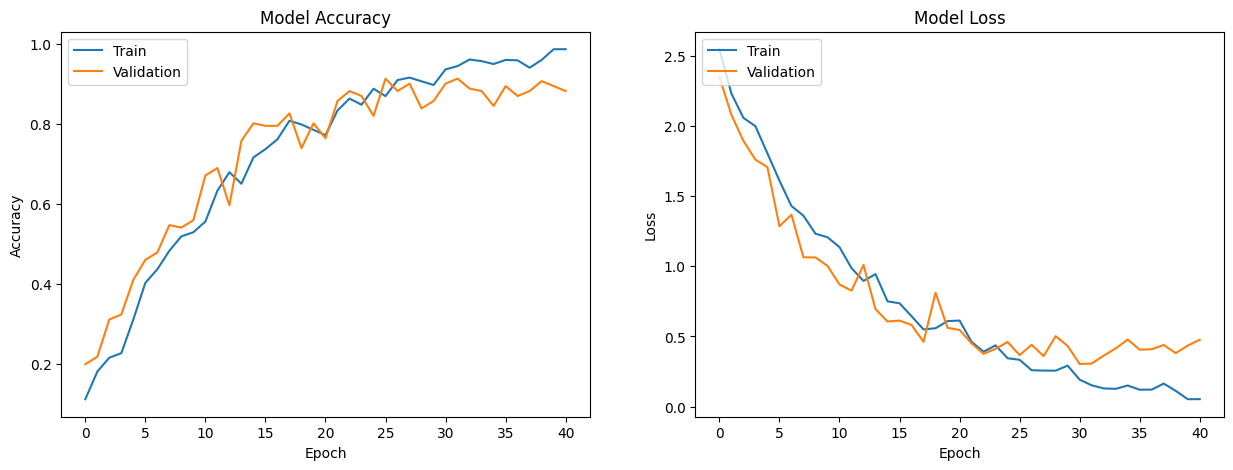

In [10]:
# Plotting function for loss and accuracy
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['model_accuracy'])  # Use 'model_accuracy' instead of 'accuracy'
    axs[0].plot(history.history['val_model_accuracy'])  # Use 'val_model_accuracy' for validation accuracy
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Now call the plot_training_history function with the history object
plot_training_history(history)

1/1 [==============================] - 0s 25ms/step


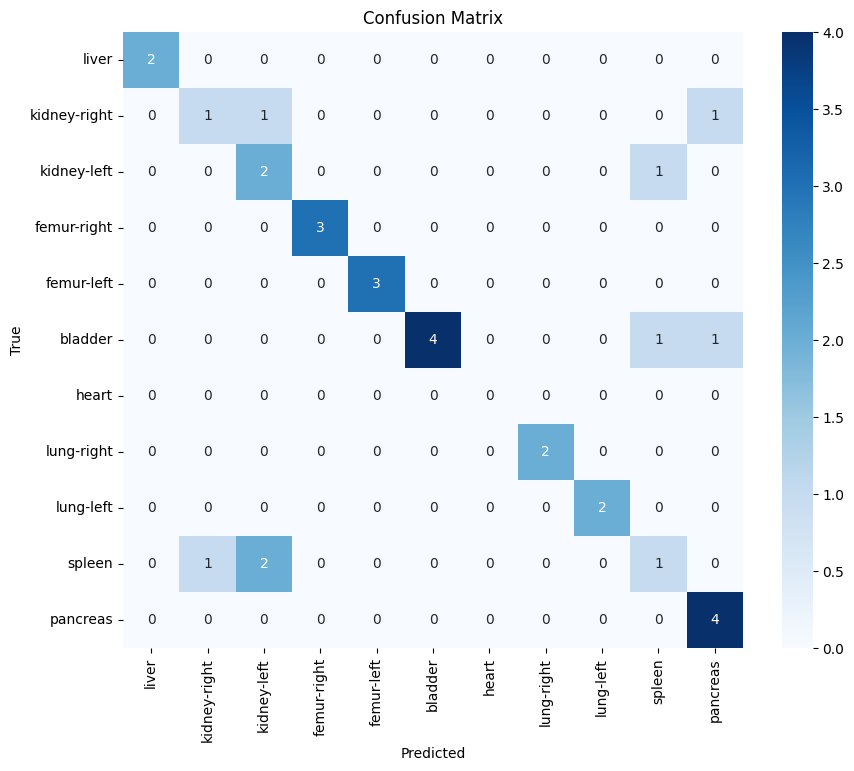

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'testing_loader' is your test data loader and 'dataset_info' contains class labels
test_videos, test_labels = next(iter(testing_loader))

predicted_classes = []
true_classes = []
for video, label in zip(test_videos, test_labels):
    prediction = trained_vivit_model.predict(tf.expand_dims(video, axis=0))
    predicted_class = np.argmax(prediction, axis=1)
    predicted_classes.extend(predicted_class)
    true_classes.append(int(label.numpy()))

# Retrieve class names from dataset_info
class_names = [dataset_info["label"][str(i)] for i in range(len(dataset_info["label"]))]

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=range(len(class_names)))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [13]:
#summary of the model
trained_vivit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 28, 1)]      0         []                            
                                                                                                  
 tubelet_embedding (Tubelet  (None, 27, 128)              65664     ['input_1[0][0]']             
 Embedding)                                                                                       
                                                                                                  
 positional_encoder (Positi  (None, 27, 128)              3456      ['tubelet_embedding[0][0]']   
 onalEncoder)                                                                                     
                                                                                              

## Inference

In [14]:
import io
import numpy as np
import imageio
import ipywidgets
import tensorflow as tf

SAMPLE_COUNT = 25
sample_videos, sample_labels = next(iter(testing_loader))
sample_videos, sample_labels = sample_videos[:SAMPLE_COUNT], sample_labels[:SAMPLE_COUNT]

actual_labels = []
predicted_labels = []
generated_gifs = []

for index, (video_sample, label) in enumerate(zip(sample_videos, sample_labels)):
    # Process and convert the tensor for GIF generation
    video_sample_np = video_sample.numpy()
    if video_sample_np.ndim == 3:  # Checking if the tensor is 3D (single frame)
        video_sample_np = video_sample_np[None, ...]  # Adding a frame dimension
    if video_sample_np.shape[-1] == 1:  # Checking if the tensor is grayscale
        video_sample_np = np.repeat(video_sample_np, 3, axis=-1)  # Converting to RGB

    video_sample_np = (video_sample_np * 255).astype(np.uint8)

    # Creating GIF from the processed video sample
    with io.BytesIO() as gif_buffer:
        imageio.mimsave(gif_buffer, video_sample_np, "GIF", fps=5)
        generated_gifs.append(gif_buffer.getvalue())

    # Predicting the class of the video sample
    model_output = trained_vivit_model.predict(tf.expand_dims(video_sample, axis=0))[0]
    predicted_class = np.argmax(model_output, axis=0)

    actual_labels.append(label.numpy().astype("int"))
    predicted_labels.append(predicted_class)

def construct_image_box(widget, caption):
    """
    Construct a box layout to display an image with its caption.
    """
    # Creating the caption
    caption_html = ipywidgets.HTML(value=f"'{caption}'" if caption is not None else str(caption))

    # Creating a box to hold the image
    image_box = ipywidgets.widgets.Box()
    image_box.children = [widget]

    # Assembling the image and its caption into a vertical layout
    vertical_box = ipywidgets.widgets.VBox()
    vertical_box.layout.align_items = "center"
    vertical_box.children = [caption_html, image_box]
    return vertical_box

image_boxes = []
for i in range(SAMPLE_COUNT):
    image_widget = ipywidgets.widgets.Image(value=generated_gifs[i], width=100, height=100)
    actual_class_name = dataset_info["label"][str(actual_labels[i])]
    predicted_class_name = dataset_info["label"][str(predicted_labels[i])]
    image_caption = f"Actual: {actual_class_name} | Predicted: {predicted_class_name}"

    image_boxes.append(construct_image_box(image_widget, image_caption))

ipywidgets.widgets.GridBox(
    image_boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)


1/1 [==============================] - 0s 28ms/step


GridBox(children=(VBox(children=(HTML(value="'Actual: pancreas | Predicted: pancreas'"), Box(children=(Image(v…